In [166]:
import numpy as np
import warnings
from scipy.io import loadmat
from LFSpy import LocalFeatureSelection
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn import datasets
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
np.random.seed(905)


In [133]:
# !wget 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'


In [151]:
t = pd.read_csv('data/iris.csv', sep=',')



In [154]:
datasets.load_iris()

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [171]:
data = t.drop(['species'],axis=1).to_numpy()
le = preprocessing.LabelEncoder()
labels = le.fit_transform(t['species'].to_numpy())

In [181]:

def load_dataset(name, m=0):
    '''
    Loads a test/demo dataset.
    '''
    print('Loading dataset ' + name + '...')
    if name is 'sample':
        mat = loadmat('data/matlab_Data')
        training_data = mat['Train'].T
        training_labels = mat['TrainLables'][0]
        testing_data = mat['Test'].T
        testing_labels = mat['TestLables'][0]
        
    elif name is 'iris':
        # we only take the first two classes for binary classification
        train_idx = np.arange(0, 100, 2)
        test_idx = np.arange(1, 100, 2)
        
        iris = data

        if m > 0:
                iris = add_noise_vars(data, m)
#         iris = t.drop(['species'],axis=1).to_numpy()
        training_data = iris[train_idx,:]
        training_labels = labels[train_idx]
        testing_data = iris[test_idx,:]
        testing_labels = labels[test_idx]
#         training_data = iris.data[train_idx,:]
#         training_labels = iris.target[train_idx]
#         testing_data = iris.data[test_idx,:]
#         testing_labels = iris.target[test_idx]
    
    return training_data, training_labels, testing_data, testing_labels

In [138]:

def add_noise_vars(x, m, std_range=[0,3]):
    '''
    Adds m Gaussian noise variables to data array x. Gaussian distribution have 
    zero mean with standard deviations sampled from a uniform distribution on
    std_range.
    '''
    n = x.shape[0]
    stds = np.random.uniform(low=std_range[0], high=std_range[1], size=m)
    noise_vars = [np.random.normal(loc=0.0, scale=s, size=[n,]) for s in stds]
    return np.hstack((x, np.stack(noise_vars).T))

In [139]:
def results_lfspy(x_train, y_train, x_test, y_test):
    '''
    Trains an tests and LFS model using default parameters on the given dataset.
    '''
    print('Training and testing an LFS model with default parameters.\nThis may take a few minutes...')
    lfs = LocalFeatureSelection(rr_seed=777)
    pipeline = Pipeline([('classifier', lfs)])
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)
    score = pipeline.score(x_test, y_test)
    
    return score, y_pred

In [140]:

def results_rforest(x_train, y_train, x_test, y_test):
    print('Training and testing a Random Forest with default parameters.')
    rfc = RandomForestClassifier(random_state=777)
    pipeline = Pipeline([('classifier', rfc)])
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)
    score = pipeline.score(x_test, y_test)
    
    return score, y_pred


In [141]:

def results_fsvm(x_train, y_train, x_test, y_test):
    print('Training and testing a SVM with default parameters with F-stat feature selection (25% of features selected).')
    svm = LinearSVC(random_state=777)
    sel = SelectKBest(f_classif, k=int(0.25*x_train.shape[1]))
    pipeline = Pipeline([('feat_sel', sel), ('classifier', svm)])
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)
    score = pipeline.score(x_test, y_test)
    
    return score, y_pred

In [142]:
 from joblib import dump, load

In [174]:

training_data, training_labels, testing_data, testing_labels = load_dataset('sample')
# lfs_model = results_lfspy(training_data, training_labels, testing_data, testing_labels)
# rfc_model = results_rforest(training_data, training_labels, testing_data, testing_labels)
# svm_model = results_fsvm(training_data, training_labels, testing_data, testing_labels)

# dump(lfs_model, 'lfs_model.joblib')
# dump(rfc_model, 'rfc_model.joblib')
# dump(svm_model, 'svm_model.joblib')

score_lfs, y_pred_lfs = results_lfspy(training_data, training_labels, testing_data, testing_labels)
score_rfc, y_pred_rfc = results_rforest(training_data, training_labels, testing_data, testing_labels)
score_svm, y_pred_svm = results_fsvm(training_data, training_labels, testing_data, testing_labels)

training_data, training_labels, testing_data, testing_labels = load_dataset('iris')
score_lfs_iris, y_pred_lfs_iris = results_lfspy(training_data, training_labels, testing_data, testing_labels)
score_rfc_iris, y_pred_rfc_iris = results_rforest(training_data, training_labels, testing_data, testing_labels)
score_svm_iris, y_pred_svm_iris = results_fsvm(training_data, training_labels, testing_data, testing_labels)

# Plot the comparison of results
scores = [score_lfs, score_rfc, score_svm]
scores_iris = [score_lfs_iris, score_rfc_iris, score_svm_iris]
with open('result-1.npy', 'wb') as f:
    np.save(f, scores)
    np.save(f, scores_iris)

Loading dataset iris...
Training and testing an LFS model with default parameters.
This may take a few minutes...
Training and testing a Random Forest with default parameters.
Training and testing a SVM with default parameters with F-stat feature selection (25% of features selected).


In [144]:
def plotScores(scores, title=None):
    '''
    Plot classification scores.
    '''
    plt.figure()
    plt.bar(['LFS','RFC','SVM'], scores)
    plt.ylim([0,1])    

    for i, v in enumerate(scores):
        plt.text(i - 0.1, 0.4, '{:.{}f}'.format(v,2), size=12)
    
    plt.title(title, fontsize=14)
    plt.savefig(title+'.png', bbox_inches='tight', pad_inches=0.1, dpi=300)
    return None

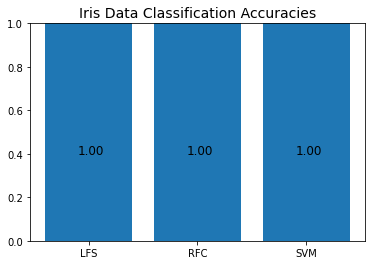

In [175]:

plotScores(scores, 'Sample Data Classification Accuracies')
plotScores(scores_iris, 'Iris Data Classification Accuracies')

In [146]:
# with open('result.npy', 'rb') as f:
#     a = np.load(f)
#     b = np.load(f)
#     c = np.load(f)
# # Plot the results
# plt.figure()
# plt.plot(mlist, Score_LFS)
# plt.plot(mlist, Score_RFC)
# plt.plot(mlist, Score_SVM)
# plt.vlines(100, 0, 1.2, linestyles='dashed')
# plt.ylim([0,1.2]) 

# #plt.xlabel('Number of Noise Features')
# plt.title('Classification Accuracy by Number of Added Noise Variables', fontsize=14)
# plt.legend(['LFS','Random Forest','SVM'], loc='lower right')
# plt.show()

In [183]:
np.load('result-2-Score_RFC.npy')

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Loading dataset iris...
Training and testing an LFS model with default parameters.
This may take a few minutes...
Training and testing a Random Forest with default parameters.
Training and testing a SVM with default parameters with F-stat feature selection (25% of features selected).
Loading dataset iris...
Training and testing an LFS model with default parameters.
This may take a few minutes...
Training and testing a Random Forest with default parameters.
Training and testing a SVM with default parameters with F-stat feature selection (25% of features selected).
Loading dataset iris...
Training and testing an LFS model with default parameters.
This may take a few minutes...
Training and testing a Random Forest with default parameters.
Training and testing a SVM with default parameters with F-stat feature selection (25% of features selected).
Loading dataset iris...
Training and testing an LFS model with default parameters.
This may take a few minutes...
Training and testing a Random F

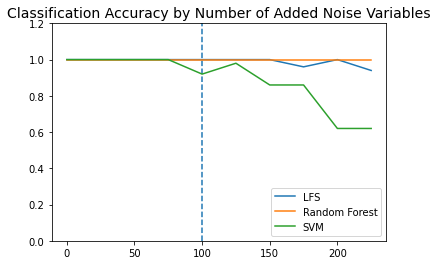

In [182]:

# %% Compare across number of noise variables on Iris dataset
Score_LFS = []
Score_SVM = []
Score_RFC = []
mlist = np.arange(0, 250, 25)
for m in mlist:
    training_data, training_labels, testing_data, testing_labels = load_dataset('iris', m=m)
    
    s1, _ = results_lfspy(training_data, training_labels, testing_data, testing_labels)
    s2, _ = results_rforest(training_data, training_labels, testing_data, testing_labels)
    s3, _ = results_fsvm(training_data, training_labels, testing_data, testing_labels)
    
    Score_LFS.append(s1)
    Score_RFC.append(s2)
    Score_SVM.append(s3)

# Save results 
np.save('result-2-Score_RFC.npy', Score_RFC)
np.save('result-2-Score_LFS.npy', Score_LFS)
np.save('result-2-Score_SVM.npy', Score_SVM)

# with open('result-2.npy', 'wb') as f:
#     np.save(f, Score_RFC)
#     np.save(f, Score_LFS)
#     np.save(f, Score_SVM)
    
# Plot the results
plt.figure()
plt.plot(mlist, Score_LFS)
plt.plot(mlist, Score_RFC)
plt.plot(mlist, Score_SVM)
plt.vlines(100, 0, 1.2, linestyles='dashed')
plt.ylim([0,1.2]) 

#plt.xlabel('Number of Noise Features')
plt.title('Classification Accuracy by Number of Added Noise Variables', fontsize=14)
plt.legend(['LFS','Random Forest','SVM'], loc='lower right')
plt.savefig('IrisData_noise_Results.png', bbox_inches='tight', pad_inches=0.1, dpi=300)
plt.show()

In [148]:
# %% GenData Experiment
def create_dataset(n_samples, n_features, n_informative, n_redundant, n_repeated, n_clusters):
    '''
    Create a synthetic dataset with desired properties.
    '''    
    X, Y = datasets.make_classification(n_samples=n_samples, 
                                        n_features=n_features, 
                                        n_informative=n_informative, 
                                        n_redundant=n_redundant, 
                                        n_repeated=n_repeated, 
                                        n_classes=2, 
                                        n_clusters_per_class=n_clusters, 
                                        weights=None, 
                                        flip_y=0.10, 
                                        class_sep=1., 
                                        hypercube=True, 
                                        shift=None, 
                                        scale=1.0, 
                                        shuffle=True, 
                                        random_state=321)
    return X, Y

In [149]:
def runExperiment():
    '''
    Run an example experiment showing the effect of redundant variables and 
    repeated variables in a p >> n setting.
    '''
    clusters = [1, 2, 3]
    param = [[50, 5, 5, 0, 0],
             [50, 45, 5, 40, 0],
             [50, 45, 5, 0, 40],
             [50, 45, 5, 20, 20]]

    scores = np.zeros((len(clusters), len(param), 3), dtype=float)

    for c, nc in enumerate(clusters):
                        
        for (i,p) in enumerate(param):
            X, Y = create_dataset(p[0], p[1], p[2], p[3], p[4], nc)
            training_data = X[:40]
            training_labels = Y[:40]
            testing_data = X[40:]
            testing_labels = Y[40:]
    
            scores[c,i,0], _ = results_lfspy(training_data, training_labels, testing_data, testing_labels)
            scores[c,i,1], _ = results_rforest(training_data, training_labels, testing_data, testing_labels)
            scores[c,i,2], _ = results_fsvm(training_data, training_labels, testing_data, testing_labels)

    return scores

def plotScoresGrouped(scores, title=None):
    '''
    Plot classification scores grouped by setting
    '''
    n, l, nclf = scores.shape
    ind = np.arange(l)
    fig, ax = plt.subplots(n,1,figsize=(8,6))
    
    for c in range(n):
        slfs = np.squeeze(scores[c,:,0])
        srfc = np.squeeze(scores[c,:,1])
        ssvm = np.squeeze(scores[c,:,2])
        
        width = 0.3
    
        ax[c].bar(ind - width, slfs, width, label='LFS')
        ax[c].bar(ind, srfc, width, label='RFC')
        ax[c].bar(ind + width, ssvm, width, label='SVM')
        
        ax[c].set_ylim([0,1])
        ax[c].set(ylabel='{} Cluster(s)'.format(c+1))
        
        for i, v in enumerate(slfs):
            ax[c].text(i - width - 0.13, 0.3, '{:.{}f}'.format(v,2), size=12)
        for i, v in enumerate(srfc):
            ax[c].text(i - 0.13, 0.3, '{:.{}f}'.format(v,2), size=12)
        for i, v in enumerate(ssvm):
            ax[c].text(i + width -0.13, 0.3, '{:.{}f}'.format(v,2), size=12)
        
        if c == 0:
            fig.suptitle(title, fontsize=14)
            ax[c].legend()
            ax[c].xaxis.set_visible(False)
        if c == 1:
            plt.ylabel('Accuracy')
            ax[c].xaxis.set_visible(False)
        if c == 2:
            plt.xticks(range(4), labels=['r=0, s=0','r=40, s=0','r=0, s=40', 'r=20, s=20'])

    plt.savefig('GenDataCompare4.png', bbox_inches='tight', pad_inches=0.1, dpi=300)    
    return None

Training and testing an LFS model with default parameters.
This may take a few minutes...
Training and testing a Random Forest with default parameters.
Training and testing a SVM with default parameters with F-stat feature selection (25% of features selected).
Training and testing an LFS model with default parameters.
This may take a few minutes...
Training and testing a Random Forest with default parameters.
Training and testing a SVM with default parameters with F-stat feature selection (25% of features selected).
Training and testing an LFS model with default parameters.
This may take a few minutes...


/Users/ebuka/.virtualenvs/computer_tool/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training and testing a Random Forest with default parameters.
Training and testing a SVM with default parameters with F-stat feature selection (25% of features selected).
Training and testing an LFS model with default parameters.
This may take a few minutes...


/Users/ebuka/.virtualenvs/computer_tool/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training and testing a Random Forest with default parameters.
Training and testing a SVM with default parameters with F-stat feature selection (25% of features selected).
Training and testing an LFS model with default parameters.
This may take a few minutes...


/Users/ebuka/.virtualenvs/computer_tool/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training and testing a Random Forest with default parameters.
Training and testing a SVM with default parameters with F-stat feature selection (25% of features selected).
Training and testing an LFS model with default parameters.
This may take a few minutes...
Training and testing a Random Forest with default parameters.
Training and testing a SVM with default parameters with F-stat feature selection (25% of features selected).
Training and testing an LFS model with default parameters.
This may take a few minutes...


/Users/ebuka/.virtualenvs/computer_tool/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training and testing a Random Forest with default parameters.
Training and testing a SVM with default parameters with F-stat feature selection (25% of features selected).
Training and testing an LFS model with default parameters.
This may take a few minutes...
Training and testing a Random Forest with default parameters.
Training and testing a SVM with default parameters with F-stat feature selection (25% of features selected).
Training and testing an LFS model with default parameters.
This may take a few minutes...


/Users/ebuka/.virtualenvs/computer_tool/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training and testing a Random Forest with default parameters.
Training and testing a SVM with default parameters with F-stat feature selection (25% of features selected).
Training and testing an LFS model with default parameters.
This may take a few minutes...
Training and testing a Random Forest with default parameters.
Training and testing a SVM with default parameters with F-stat feature selection (25% of features selected).
Training and testing an LFS model with default parameters.
This may take a few minutes...


/Users/ebuka/.virtualenvs/computer_tool/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training and testing a Random Forest with default parameters.
Training and testing a SVM with default parameters with F-stat feature selection (25% of features selected).
Training and testing an LFS model with default parameters.
This may take a few minutes...


/Users/ebuka/.virtualenvs/computer_tool/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training and testing a Random Forest with default parameters.
Training and testing a SVM with default parameters with F-stat feature selection (25% of features selected).


/Users/ebuka/.virtualenvs/computer_tool/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


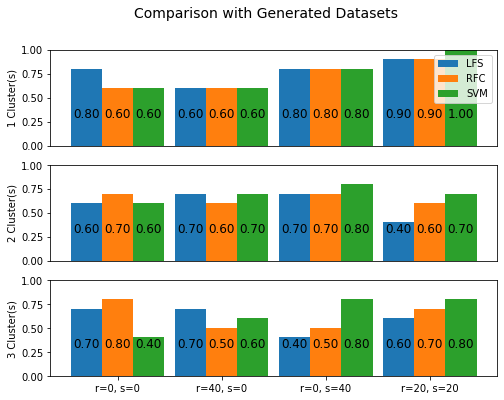

In [150]:
scores = runExperiment()
np.save("Experiment.npy", scores)
plotScoresGrouped(scores, 'Comparison with Generated Datasets')